In [1]:
# Modified from https://rumn.medium.com/custom-pytorch-image-classifier-from-scratch-d7b3c50f9fbe
# To run locally, install the following packages
# !pip install --quiet torch numpy pandas scikit-learn pillow torchvision ultralytics opencv-python requests

In [3]:
#In addition, you will have to resize the images and store them in a separate folder (not included in the repo)
from PIL import Image 
import glob
import os

paths = glob.glob("./images/*/*.jpg")
countries = set()
for path in paths:
   substr = path[9:]
   country_name = substr[:substr.find('/')]
   if not os.path.exists(f"./resnet_images/{country_name}"):
      os.makedirs(f"./resnet_images/{country_name}")

for path in glob.glob("./images/*/*.jpg"):
   image_file = Image.open(path) 
   new_image = image_file.resize((224, 224)) # image must be in this size for this vision transformer model
   new_path = f'./resnet_images/{path[9:]}'
   new_image.save(new_path)

# If you want to run this in collab, make a zip file, upload it, and use
# !unzip vit_images.zip
# !ls

# Fine-tuning EfficientNet for Geoguessr
There are a lot of strong classifier models for computer vision, which could be well suited for this task. This notebook fine-tunes EfficiencyNet_b0.

In [4]:
import torch
import torchvision

In [ ]:
model = torchvision.models.resnet18(weights="DEFAULT")
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}") # 12M
model

Total number of parameters: 11689512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import glob
from tqdm import tqdm

IMAGE_SIZE = (224,224)

image_path_list = []
label_list = []

for path in glob.glob("./resnet_images/*/*.jpg"):
   substr = path[len('./resnet_images')+1:]
   label = substr[:substr.find('/')]
   image_path_list.append(path)
   label_list.append(label)

df = pd.DataFrame()
df["image_path"] = image_path_list
df["label"] = label_list

df

,image_path,label
0,./resnet_images/Uganda/canvas_1630110574.jpg,Uganda
1,./resnet_images/Uganda/canvas_1629748954.jpg,Uganda
2,./resnet_images/Uganda/canvas_1629766624.jpg,Uganda
3,./resnet_images/Uganda/canvas_1629441091.jpg,Uganda
4,./resnet_images/Uganda/canvas_1629269512.jpg,Uganda
...,...,...
4994,./resnet_images/Italy/canvas_1629324260.jpg,Italy
4995,./resnet_images/Italy/canvas_1629411605.jpg,Italy
4996,./resnet_images/Italy/canvas_1629283408.jpg,Italy
4997,./resnet_images/Italy/canvas_1629822756.jpg,Italy


In [8]:
for country in set(df["label"]):
   if len(df[df.label == country]) < 2:
      df = df.drop(df[df.label == country].index)
      # number of data per label cannot be less than 2 (requirement for scikit train_test_split)
      # this means that some countries like Andorra will never be guessed

In [9]:
# split dataset into train and test
test_ratio = 0.2

train_df, test_df = train_test_split(df, test_size=test_ratio,
                                     stratify=df['label'], random_state = 0)

print(f"Original dataset shape: {df.shape}")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Original dataset shape: (4989, 2)
Train dataset shape: (3991, 2)
Test dataset shape: (998, 2)


In [10]:
# Data Augmentation

# this will be used during training, this will hold all the augmentation/transformation configs
training_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [11]:
# load images
class GeoguessrData(Dataset):
   def __init__(self, csv_df, class_list, transform=None):
      self.df = csv_df
      self.transform = transform
      self.class_list = class_list

   def __len__(self):
      return self.df.shape[0]

   def __getitem__(self, index):
      image = Image.open(self.df.iloc[index].image_path).convert('RGB')
      label = self.class_list.index(self.df.iloc[index].label)

      if self.transform:
         image = self.transform(image)

      return image, label

In [12]:
CLASS_LIST = list(set(label_list))
train_data_object = GeoguessrData(train_df, CLASS_LIST, training_transform)
test_data_object = GeoguessrData(test_df, CLASS_LIST, test_transform)

In [13]:
# Dataloader
BATCH_SIZE = 32
# now define dataloader, this will load the images batches from CustomTrainingData object
train_loader = DataLoader(train_data_object, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data_object, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = len(CLASS_LIST)
CHANNELS = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
import gc
torch.cuda.empty_cache() # There can be memory issues for larger models
gc.collect()

20

In [16]:
# Initialize model
model = torchvision.models.resnet18(weights="DEFAULT").to(device)
model.fc= nn.Linear(in_features=512, out_features=NUM_CLASSES).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}") # 11M

Total number of parameters: 11227812


In [18]:
device

device(type='cuda')

In [19]:
# Training loop
model.to(device)
for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Accuracy on test set: {accuracy:.2f}%')
    print('-----------------------------')

print('Training finished!')

# Save the model
torch.save(model.state_dict(), 'model/resnet/Geoguessr_classifier.pt')


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 3.3609


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  4%|▍         | 1/25 [00:19<07:57, 19.90s/it]

Epoch [1/25]
Accuracy on test set: 24.75%
Precision: 0.1351
Recall: 0.2475
F1 Score: 0.1321
-----------------------------
Epoch [2/25], Loss: 3.0609


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  8%|▊         | 2/25 [00:37<07:00, 18.27s/it]

Epoch [2/25]
Accuracy on test set: 29.36%
Precision: 0.1842
Recall: 0.2936
F1 Score: 0.1920
-----------------------------
Epoch [3/25], Loss: 2.8276


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/25 [00:53<06:23, 17.42s/it]

Epoch [3/25]
Accuracy on test set: 29.86%
Precision: 0.1825
Recall: 0.2986
F1 Score: 0.1957
-----------------------------
Epoch [4/25], Loss: 2.6253


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 16%|█▌        | 4/25 [01:09<05:56, 16.99s/it]

Epoch [4/25]
Accuracy on test set: 28.86%
Precision: 0.2307
Recall: 0.2886
F1 Score: 0.1942
-----------------------------
Epoch [5/25], Loss: 2.4249


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 5/25 [01:29<05:56, 17.85s/it]

Epoch [5/25]
Accuracy on test set: 32.36%
Precision: 0.2884
Recall: 0.3236
F1 Score: 0.2539
-----------------------------
Epoch [6/25], Loss: 2.2195


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 24%|██▍       | 6/25 [01:51<06:10, 19.50s/it]

Epoch [6/25]
Accuracy on test set: 28.86%
Precision: 0.2823
Recall: 0.2886
F1 Score: 0.2499
-----------------------------
Epoch [7/25], Loss: 2.0624


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 28%|██▊       | 7/25 [02:15<06:13, 20.75s/it]

Epoch [7/25]
Accuracy on test set: 31.56%
Precision: 0.3361
Recall: 0.3156
F1 Score: 0.2812
-----------------------------
Epoch [8/25], Loss: 1.8370


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 32%|███▏      | 8/25 [02:35<05:51, 20.65s/it]

Epoch [8/25]
Accuracy on test set: 29.86%
Precision: 0.3625
Recall: 0.2986
F1 Score: 0.2851
-----------------------------
Epoch [9/25], Loss: 1.6121


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 36%|███▌      | 9/25 [02:54<05:21, 20.09s/it]

Epoch [9/25]
Accuracy on test set: 34.17%
Precision: 0.3266
Recall: 0.3417
F1 Score: 0.3063
-----------------------------
Epoch [10/25], Loss: 1.3950


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 40%|████      | 10/25 [03:13<04:58, 19.90s/it]

Epoch [10/25]
Accuracy on test set: 33.57%
Precision: 0.3344
Recall: 0.3357
F1 Score: 0.3019
-----------------------------
Epoch [11/25], Loss: 1.1548


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 44%|████▍     | 11/25 [03:34<04:39, 19.96s/it]

Epoch [11/25]
Accuracy on test set: 32.87%
Precision: 0.3223
Recall: 0.3287
F1 Score: 0.2944
-----------------------------
Epoch [12/25], Loss: 0.9144


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 48%|████▊     | 12/25 [03:54<04:21, 20.14s/it]

Epoch [12/25]
Accuracy on test set: 37.37%
Precision: 0.3456
Recall: 0.3737
F1 Score: 0.3337
-----------------------------
Epoch [13/25], Loss: 0.6629


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 52%|█████▏    | 13/25 [04:19<04:20, 21.73s/it]

Epoch [13/25]
Accuracy on test set: 36.97%
Precision: 0.3421
Recall: 0.3697
F1 Score: 0.3447
-----------------------------
Epoch [14/25], Loss: 0.4798


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 56%|█████▌    | 14/25 [04:43<04:04, 22.22s/it]

Epoch [14/25]
Accuracy on test set: 38.28%
Precision: 0.3483
Recall: 0.3828
F1 Score: 0.3432
-----------------------------
Epoch [15/25], Loss: 0.4060


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 15/25 [05:06<03:45, 22.50s/it]

Epoch [15/25]
Accuracy on test set: 32.06%
Precision: 0.3767
Recall: 0.3206
F1 Score: 0.3313
-----------------------------
Epoch [16/25], Loss: 0.2728


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 64%|██████▍   | 16/25 [05:29<03:23, 22.61s/it]

Epoch [16/25]
Accuracy on test set: 37.47%
Precision: 0.3609
Recall: 0.3747
F1 Score: 0.3549
-----------------------------
Epoch [17/25], Loss: 0.1823


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 68%|██████▊   | 17/25 [05:54<03:06, 23.29s/it]

Epoch [17/25]
Accuracy on test set: 37.07%
Precision: 0.3743
Recall: 0.3707
F1 Score: 0.3447
-----------------------------
Epoch [18/25], Loss: 0.1389


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 72%|███████▏  | 18/25 [06:18<02:45, 23.68s/it]

Epoch [18/25]
Accuracy on test set: 38.28%
Precision: 0.3544
Recall: 0.3828
F1 Score: 0.3606
-----------------------------
Epoch [19/25], Loss: 0.1072


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 76%|███████▌  | 19/25 [06:43<02:24, 24.07s/it]

Epoch [19/25]
Accuracy on test set: 36.77%
Precision: 0.3673
Recall: 0.3677
F1 Score: 0.3522
-----------------------------
Epoch [20/25], Loss: 0.1394


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|████████  | 20/25 [07:08<02:01, 24.32s/it]

Epoch [20/25]
Accuracy on test set: 31.86%
Precision: 0.3670
Recall: 0.3186
F1 Score: 0.3133
-----------------------------
Epoch [21/25], Loss: 0.1598


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 84%|████████▍ | 21/25 [07:32<01:36, 24.10s/it]

Epoch [21/25]
Accuracy on test set: 38.38%
Precision: 0.3593
Recall: 0.3838
F1 Score: 0.3426
-----------------------------
Epoch [22/25], Loss: 0.1223


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████▊ | 22/25 [07:54<01:10, 23.52s/it]

Epoch [22/25]
Accuracy on test set: 36.57%
Precision: 0.3264
Recall: 0.3657
F1 Score: 0.3306
-----------------------------
Epoch [23/25], Loss: 0.1055


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|█████████▏| 23/25 [08:14<00:45, 22.62s/it]

Epoch [23/25]
Accuracy on test set: 32.97%
Precision: 0.3294
Recall: 0.3297
F1 Score: 0.3141
-----------------------------
Epoch [24/25], Loss: 0.1119


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|█████████▌| 24/25 [08:39<00:23, 23.35s/it]

Epoch [24/25]
Accuracy on test set: 34.07%
Precision: 0.3210
Recall: 0.3407
F1 Score: 0.3189
-----------------------------
Epoch [25/25], Loss: 0.1187


/root/miniconda3/envs/vision/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 25/25 [09:01<00:00, 21.65s/it]

Epoch [25/25]
Accuracy on test set: 29.46%
Precision: 0.3612
Recall: 0.2946
F1 Score: 0.3067
-----------------------------
Training finished!


# Results
It appears that the final test accuracy was 29.46%, with the best result being around 40%.

This is very low compared to our Multimodal LLMs. 

We have only trained it for 25 epochs, and so it's possible that further training, with the right hyperparameters, could lead to better results.



In [22]:
# Inference
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNELS = 3

new_model = model = torchvision.models.resnet18(weights=None).to(device)
new_model.fc= nn.Linear(in_features=512, out_features=NUM_CLASSES)

# Load the saved state dictionary
state_dict = torch.load('model/resnet/Geoguessr_classifier.pt')
# Load the state dictionary into your model
new_model.load_state_dict(state_dict)
# Set the model to evaluation mode
new_model.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# this will be used during testing / infernece, wo don't want any kind of additional transformation applied at the time of running model prediction in test / production inviroment
test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                             transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [24]:
def plot_image(image):
   """
   Plot an image using matplotlib.

   Parameters:
   image : PIL.Image or numpy.ndarray
      The image to be plotted. Can be a PIL Image object or a numpy array.
   """
   # Convert PIL Image to numpy array if necessary
   if isinstance(image, Image.Image):
      image = np.array(image)

   plt.imshow(image)

   plt.axis('off')  # Hide axes
   plt.show()

In [25]:
# Inference
def predict(model, image_path):
   image_pil = Image.open(image_path).convert('RGB')
   image = test_transform(image_pil).unsqueeze(0).to(device)

   with torch.no_grad():
      output = model(image)
      # Apply softmax to the output
      softmax_output = F.softmax(output, dim=1)

      print(f'Model raw output: {output}')
      print(f'Softmax output: {softmax_output}')

      # Get the predicted class and its confidence
      confidence, predicted = torch.max(softmax_output, 1)

      predicted_class = CLASS_LIST[predicted.item()]
      confidence = confidence.item()

   print(f'Predicted class: {predicted_class}')
   print(f'Confidence: {confidence:.4f}')
   plot_image(image_pil)

In [26]:
import glob
import random

def get_random_image():
   """Return a dict of path image with its corresponding full country name
   args:
      None

   returns:
      dict with fields "country" and "image_path"
   """

   paths = glob.glob("./resnet_images/*/*.jpg")
   image_path = random.choice(paths)
   # ex. ./e_net_b0_images/Argentina/canvas_1629303518.jpg
   substr = path[len('./resnet_images')+1:]
   country_name = substr[:substr.find('/')]
   
   return {"country": country_name, "image_path": image_path}

Image from: Costa Rica
Model raw output: tensor([[ -2.0270, -16.8671, -16.4421,   0.6467,  -7.6953,  -6.0348,  -6.8398,
         -15.7740, -10.0743, -15.0413,  -7.3812,  -6.8456,  -6.7494, -18.9498,
         -12.5289, -14.1163,   0.3398,  -4.7040, -10.5378,  -1.5290, -14.7753,
         -21.1549, -16.4198,  -3.9634,  -9.8267,  -6.5704,  -1.5779, -15.0142,
         -14.8577,  -4.5042, -17.1054, -11.9829, -15.8354, -12.2499,  -6.0551,
          -8.4691,  -3.0586,  -6.7251, -15.3634,  -9.8120,  -5.2386, -15.0251,
          -4.1488,  -6.1212, -10.4809,  -3.1234, -16.0930,  -9.4311,  -2.8415,
         -15.8878,  -6.2077, -14.0604,  -7.8612,  -3.1549,  -3.2556,  -4.1931,
          -0.8829, -13.0885, -11.2027,  -6.1417, -10.0666,  -2.5697, -15.6835,
          -1.0506, -14.8080,  -7.3211,  -0.8376,  -2.1266, -11.6879,  -6.1386,
         -10.2218, -13.7793, -13.0736, -12.8646,  -6.0715, -20.6040,  -6.4768,
          -5.0507,  -7.0983, -15.9642,  -1.4233, -13.7725,  -7.6390,  -8.4255,
          -

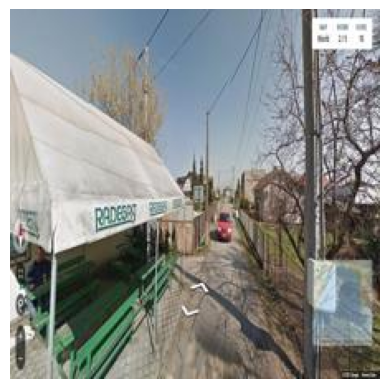

In [27]:
from IPython.display import Image as notebookImage

image = get_random_image()
print("Image from:", image["country"])
notebookImage(filename=image["image_path"])

predict(new_model, image["image_path"])